In [1]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

seed = 42
np.random.seed(seed=seed)
# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 400, 4000).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.random.choice(np.arange(1, 401), size=200, replace=False)
indices = [np.abs(x_dense.flatten() - x).argmin() for x in integer_points]
y_integers = y_dense[indices]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('mu.txt', 
           y_integers,
           fmt='%.6f',
           header='真实均值')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

colors = ['#2ca02c',]

fig.add_trace(go.Scatter(
    x=integer_points,
    y=y_integers,
    mode='markers',
    name='被选点',
    marker=dict(
        color=colors[0],
        size=8,
        line=dict(width=1, color='DarkSlateGrey')
)))

fig.update_layout(
    title='高斯过程曲线与选点结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=1080,
    width=1920,
    legend=dict(
        title='标志',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()

In [2]:
eigvals = np.linalg.eigvals(cov_matrix)
print("最小特征值:", np.min(eigvals))
print("负特征值数量:", np.sum(eigvals < 0))

最小特征值: 0.001000000000245574
负特征值数量: 0


In [3]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel,Matern
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

np.random.seed(seed=seed)
# 定义核函数
kernel = ConstantKernel(25.0) * Matern(length_scale=4, nu=2.5) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 201, 4000).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.random.choice(np.arange(1, 201), size=200, replace=False)
indices = [np.abs(x_dense.flatten() - x).argmin() for x in integer_points]
y_integers = y_dense[indices]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 5种不同颜色
colors = ['#2ca02c',]

fig.add_trace(go.Scatter(
    x=integer_points,
    y=y_integers,
    mode='markers',
    name='被选点',
    marker=dict(
        color=colors[0],
        size=8,
        line=dict(width=1, color='DarkSlateGrey')
)))

fig.update_layout(
    title='高斯过程曲线与选点结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=1080,
    width=1920,
    legend=dict(
        title='标志',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()


验证结果:
对角线均值: 1.000000 (目标: 1.0)
最小特征值: 0.000593 (应>0)


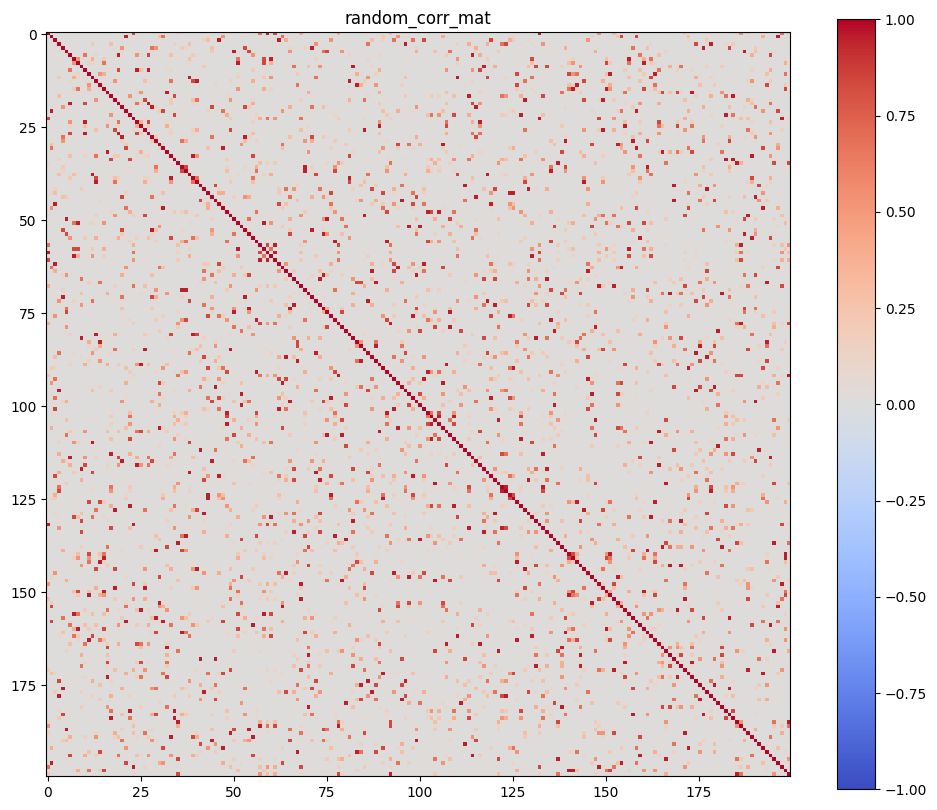

In [4]:
# 验证矩阵性质
print("验证结果:")
print(f"对角线均值: {np.mean(np.diag(corr_matrix)):.6f} (目标: 1.0)")
print(f"最小特征值: {np.min(np.linalg.eigvals(corr_matrix)):.6f} (应>0)")

# 可视化矩阵
plt.figure(figsize=(12,10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("random_corr_mat")
plt.show()

验证结果:
方差范围: 25.66-142.44 (目标: 25-144)
最小特征值: 0.026567 (应>0)


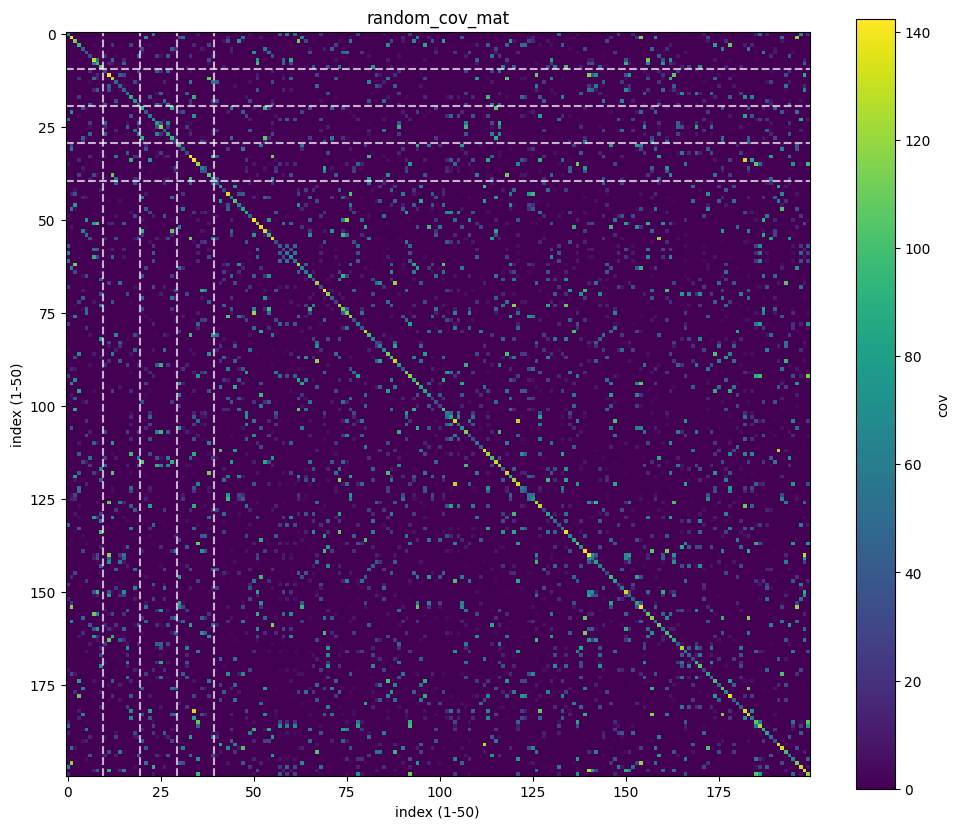

In [5]:
# 随机分配噪声
np.random.seed(seed)  
variances = np.random.uniform(low=25, high=144, size=200)
std_devs = np.sqrt(variances)  

D = np.diag(std_devs)

cov_matrix = D @ corr_matrix @ D

print("验证结果:")
print(f"方差范围: {np.min(np.diag(cov_matrix)):.2f}-{np.max(np.diag(cov_matrix)):.2f} (目标: 25-144)")
print(f"最小特征值: {np.min(np.linalg.eigvals(cov_matrix)):.6f} (应>0)")

np.savetxt('group_cov.txt', 
           cov_matrix,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=25-144）\n基于分组相关性矩阵生成')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(cov_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('cov')

for g in range(1,5):
    plt.axhline(y=g*10-0.5, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=g*10-0.5, color='white', linestyle='--', alpha=0.7)

plt.title('random_cov_mat')
plt.xlabel('index (1-50)')
plt.ylabel('index (1-50)')
plt.show()


In [6]:
variances

array([ 69.57027414, 138.13500246, 112.10727908,  96.24035962,
        43.56621821,  43.56334792,  31.91194985, 128.07496135,
        96.5326864 , 109.26063676,  27.44955482, 140.41927241,
       124.06067426,  50.26835417,  46.6371711 ,  46.82513667,
        61.20482691,  87.44601536,  76.40145722,  59.65626768,
        97.81049447,  41.59976942,  59.76521318,  68.59705935,
        79.27232812, 118.43593941,  48.76118008,  86.19389817,
        95.49733369,  30.52759911,  97.29783738,  45.29237072,
        32.74113957, 137.91737893, 139.91021194, 121.19928443,
        61.24903853,  36.62298157, 106.42373015,  77.37814676,
        39.52254995,  83.9260523 ,  29.09223401, 133.20912785,
        55.79481781, 103.84015184,  62.09361805,  86.88809452,
        90.05852324,  46.99768021, 140.3805707 , 117.24080598,
       136.80037405, 131.4844547 ,  96.15009748, 134.70303397,
        35.53060774,  48.32196063,  30.38204738,  63.71430936,
        71.25259747,  57.29053478, 123.61976359,  67.45